<a href="https://www.kaggle.com/code/carneirofernando/analise-exploratoria-de-dados-de-logistica-loggi?scriptVersionId=131609995" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

---  
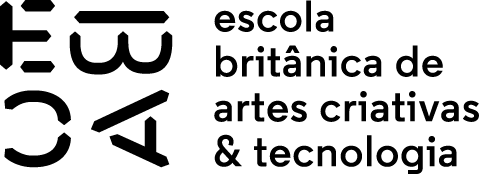
# **Análise Exploratória de Dados de Logística (Loggi):** Revelando Insights sobre a Região Metropolitana do Rio de Janeiro

Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

# **1\. Introdução**

<img src="https://github.com/carneiro-fernando/EBAC/blob/2db20be2b09968c604a78fcce3d01c6bf862bd3b/assets/loggi-logo.png?raw=true" align="center" width=450>

<img src="https://wp-admin.loggi.com/wp-content/uploads/2022/07/entregando-caixa-loggi-loggi-home_desktop-819x1024.png" align="right" width="140">

 ## **1.1 Loggi**

A Loggi é uma empresa brasileira de logística com sede na cidade de São Paulo que atua principalmente no setor de e-commerce, [fundada em 2013](https://www.loggi.com/conheca-a-loggi/) pelo empreendedor Fabien Mendez (frança) e Arthur Debert(Brasil). 

Em janeiro de 2021, a empresa atendia 637 municípios. Hoje, seu produto já está presente em [mais de 3.600 cidades](https://exame.com/exame-in/depois-de-aporte-bilionario-loggi-chega-a-2-100-cidades-do-brasil/) brasileiras, contemplando mais de 85% da população do país.

## **1.2 Loggi BUD (Benchmark for Urban Deliveries)**

O Loggi Benchmark for Urban Deliveries (BUD) é um repositório do GitHub ([link](https://github.com/loggi/loggibud)) com dados e códigos para problemas típicos que empresas de logística enfrentam: otimização das rotas de entrega, alocação de entregas nos veículos da frota com capacidade limitada, etc. 

<img src="https://github.com/carneiro-fernando/EBAC/blob/main/assets/loggibud80.png?raw=true">

Os dados são sintetizados de fontes públicas (IBGE, IPEA, etc.) e são representativos dos desafios que a startup enfrenta no dia a dia, especialmente com relação a sua escala.

> **Imagem - Pontos de entrega em orla do Rio de Janeiro**

<img src="https://github.com/loggi/loggibud/blob/master/figures/cvrp_example_1.png?raw=true" /> * *A imagem acima representa os pontos de entrega (azul) e um HUB (vermelho) na parte central do Rio de Janeiro*

## **1.3 Análise Exploratória de Dados (EDA) do Loggi BUD**.

Esta pesquisa visa encontrar soluções para otimizar as operações mais próximas das aplicações do mundo real enfrentadas pelas empresas de logística, realizando investigações em dados para descobrir padrões, detectar anomalias, testar hipóteses e verificar suposições com a ajuda de estatísticas resumidas e representações gráficas. As instâncias do mundo real disponibilizadas pela empresa Loggi ajudam a ter novas ideias, obter *insights* e, eventualmente, resolver grandes problemas de roteamento e localização.

>Nesta análise foi usado um sub conjunto dos dados originais extraídos do [Github do Loggi BUD](https://github.com/loggi/loggibud/blob/master/docs/quickstart.md). Os arquivos do tipo **[JSON](https://www.json.org/json-en.html)** foram mesclados em único arquivo que compreende todos os dados pertencentes ao **Rio de Janeiro**, ele está disponível em meu [Github - clicando aqui]('https://github.com/carneiro-fernando/EBAC/raw/main/Dataset_Loggi/deliveries.json').

In [1]:
!wget -q 'https://github.com/carneiro-fernando/EBAC/raw/main/assets/Dataset_Loggi/deliveries.json' -O deliveries.json

 Cada instância representa um conjunto de entregas que devem ser realizadas pelos veículos do **hub** regional. Os arquivos JSON tem a seguinte disposição:

```json
[
  {
    "name": "cvrp-0-df-0",
    "region": "df-0",
    "origin": {"lng": -47.802664728268745, "lat": -15.657013854445248},
    "vehicle_capacity": 180,
    "deliveries": [
      {
        "id": "ed0993f8cc70d998342f38ee827176dc",
        "point": {"lng": -47.7496622016347, "lat": -15.65879313293694},
        "size": 10
      },
      {
        "id": "c7220154adc7a3def8f0b2b8a42677a9",
        "point": {"lng": -47.75887552060412, "lat": -15.651440380492554},
        "size": 10
      },
      ...
    ]
  }
]
...


Onde:

 - **name**: uma `string` com o nome único da instância;
 - **region**: uma `string` com o nome único da região do **hub**;
 - **origin**: um `dict` com a latitude e longitude da região do **hub**;
 - **vehicle_capacity**: um `int` com a soma da capacidade de carga dos **veículos** do **hub**;
 - **deliveries**: uma `list` de `dict` com as **entregas** que devem ser realizadas.

Sendo que:

 - **id**: uma `string` com o id único da **entrega**;
 - **point**: um `dict` com a latitude e longitude da **entrega**;
 - **size**: um `int` com o tamanho ou a carga que a **entrega** ocupa no **veículo**.

# 2\. Pacotes e bibliotecas

## **2\.1 Pacotes Nativos**

In [2]:
import json

## **2\.2 Pacotes de terceiros**

In [3]:
!pip3 install geopandas;

In [4]:
import pandas as pd
import geopy
import geopandas
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon, Point
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from IPython.display import Image

# 3\. Exploração dos Dados

## **3\.1 Coleta de Dados**

Carregando o arquivo JSON transferido para um dicionário Python

In [5]:
with open('deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file)

Vamos verificar o cabeçalho e a primeira linha do dicionário gerado:

In [6]:
cabecalho, valor = [],[]
count = 0

for key in data[0].keys():
    cabecalho.append(key)
    valor.append(data[0][key])
    count += 1
    if count == 3:
        break

print(f"{cabecalho}\n{valor}")

['name', 'region', 'origin']
['cvrp-1-rj-90', 'rj-1', {'lng': -43.36148694575315, 'lat': -22.812536432313156}]


## **3\.2 *Wrangling***

Transfomando o dicionário Python em um DataFrame Pandas

In [7]:
deliveries_df = pd.DataFrame(data)

Verificando as primeiras linhas do DataFrame

In [8]:
deliveries_df.head()

name region                                             origin  \
0  cvrp-1-rj-90   rj-1  {'lng': -43.36148694575315, 'lat': -22.8125364...   
1  cvrp-0-rj-90   rj-0  {'lng': -43.09887838388887, 'lat': -22.8662298...   
2  cvrp-2-rj-90   rj-2  {'lng': -43.57079247355232, 'lat': -22.9067160...   
3  cvrp-4-rj-90   rj-4  {'lng': -43.24316762611806, 'lat': -22.9139111...   
4  cvrp-3-rj-90   rj-3  {'lng': -43.1957595139539, 'lat': -22.95566161...   

   vehicle_capacity                                         deliveries  
0               180  [{'id': 'e200694f135c873338231965ec97eb58', 'p...  
1               180  [{'id': '3c1c3242fbb7c6d27c5b0cf2a619a5d4', 'p...  
2               180  [{'id': '2f92a806e57dfb3c0a961f8ddae21454', 'p...  
3               180  [{'id': 'fe4e646b03a69197991d465340fce592', 'p...  
4               180  [{'id': '865871318c6d21bec894e1486fe05476', 'p...



> É possível notar que ambas as colunas *origin* e *deliveries* tem seus dados aninhados em dicionário e lista respectivamente, será necessário extraí-los num processo chamado ***flattening*** (achatamento) ou ***unnesting*** (desaninhamento).




#### **Normalização da coluna *origin*:**

In [9]:
col_origin_df = pd.json_normalize(deliveries_df['origin'])
col_origin_df.head()

lng        lat
0 -43.361487 -22.812536
1 -43.098878 -22.866230
2 -43.570792 -22.906716
3 -43.243168 -22.913911
4 -43.195760 -22.955662

Vamos devolver os dados achatados para o DataFrame original

In [10]:
deliveries_df = pd.merge(deliveries_df, col_origin_df, how='inner', left_index=True, right_index=True)

Renomeamos as colunas novas inseridas a partir do achatamento da *origin* 

In [11]:
deliveries_df.rename(columns={'lng':'origin_lng', 'lat':'origin_lat'}, inplace=True)

Removendo a coluna original *origin*

In [12]:
deliveries_df = deliveries_df.drop("origin", axis=1)

Ajustando a ordem das colunas

In [13]:
deliveries_df = deliveries_df[["name", "region", "origin_lng", "origin_lat", "vehicle_capacity", "deliveries"]]

In [14]:
deliveries_df.head()

name region  origin_lng  origin_lat  vehicle_capacity  \
0  cvrp-1-rj-90   rj-1  -43.361487  -22.812536               180   
1  cvrp-0-rj-90   rj-0  -43.098878  -22.866230               180   
2  cvrp-2-rj-90   rj-2  -43.570792  -22.906716               180   
3  cvrp-4-rj-90   rj-4  -43.243168  -22.913911               180   
4  cvrp-3-rj-90   rj-3  -43.195760  -22.955662               180   

                                          deliveries  
0  [{'id': 'e200694f135c873338231965ec97eb58', 'p...  
1  [{'id': '3c1c3242fbb7c6d27c5b0cf2a619a5d4', 'p...  
2  [{'id': '2f92a806e57dfb3c0a961f8ddae21454', 'p...  
3  [{'id': 'fe4e646b03a69197991d465340fce592', 'p...  
4  [{'id': '865871318c6d21bec894e1486fe05476', 'p...

#### **Normalização da coluna *deliveries*:**



> Repare que a coluna `deliveries` contem dados uma lista de dados `nested` ou aninhados na estrutura do JSON. Vamos normalizar a coluna com uma operação conhecida como `explode` ou explosão que transforma cada elemento da lista em uma linha. Por fim, faremos os `flatten` ou achatamento do resultado coluna:



In [15]:
deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")
deliveries_exploded_df.head()

deliveries
0  {'id': 'e200694f135c873338231965ec97eb58', 'po...
0  {'id': 'cad58a9670a2bfdb8f70f6b2d1bd7662', 'po...
0  {'id': '3f1bf231b628f5ef6136b7fa2b7d32c', 'poi...
0  {'id': 'b06a62b25a0d640c964ea009113694c6', 'po...
0  {'id': 'f67b06f1acf601414da8ab4d61ffd1c0', 'po...

Após criar um dataset com os dados, removemos a coluna *id* que não será útil e renomeamos as colunas afim de prepará-las para retornar ao dataframe original.

In [16]:
deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)
deliveries_normalized_df.head()

delivery_size  delivery_lng  delivery_lat
0              3    -43.360664    -22.814775
0              6    -43.361185    -22.811917
0              3    -43.365789    -22.811498
0              6    -43.357451    -22.821007
0              9    -43.353322    -22.815381

Agora removemos a coluna '*deliveries*' e mesclaremos as linhas novas ao dataframe original:

In [17]:
deliveries_df = deliveries_df.drop('deliveries', axis=1)

In [18]:
deliveries_df = pd.merge(deliveries_df, deliveries_normalized_df, how="inner",  left_index=True, right_index=True)

In [19]:
deliveries_df.head()

name region  origin_lng  origin_lat  vehicle_capacity  \
0  cvrp-1-rj-90   rj-1  -43.361487  -22.812536               180   
0  cvrp-1-rj-90   rj-1  -43.361487  -22.812536               180   
0  cvrp-1-rj-90   rj-1  -43.361487  -22.812536               180   
0  cvrp-1-rj-90   rj-1  -43.361487  -22.812536               180   
0  cvrp-1-rj-90   rj-1  -43.361487  -22.812536               180   

   delivery_size  delivery_lng  delivery_lat  
0              3    -43.360664    -22.814775  
0              6    -43.361185    -22.811917  
0              3    -43.365789    -22.811498  
0              6    -43.357451    -22.821007  
0              9    -43.353322    -22.815381

Redefinimos o índice, para que faça sentido no dataframe

In [20]:
deliveries_df.reset_index(inplace=True, drop=True)
deliveries_df

name region  origin_lng  origin_lat  vehicle_capacity  \
0        cvrp-1-rj-90   rj-1  -43.361487  -22.812536               180   
1        cvrp-1-rj-90   rj-1  -43.361487  -22.812536               180   
2        cvrp-1-rj-90   rj-1  -43.361487  -22.812536               180   
3        cvrp-1-rj-90   rj-1  -43.361487  -22.812536               180   
4        cvrp-1-rj-90   rj-1  -43.361487  -22.812536               180   
...               ...    ...         ...         ...               ...   
879964  cvrp-4-rj-119   rj-4  -43.243168  -22.913911               180   
879965  cvrp-4-rj-119   rj-4  -43.243168  -22.913911               180   
879966  cvrp-4-rj-119   rj-4  -43.243168  -22.913911               180   
879967  cvrp-4-rj-119   rj-4  -43.243168  -22.913911               180   
879968  cvrp-4-rj-119   rj-4  -43.243168  -22.913911               180   

        delivery_size  delivery_lng  delivery_lat  
0                   3    -43.360664    -22.814775  
1                   6    -43.361185    -22.811917  
2                   3    -43.365789    -22.811498  
3                   6    -43.357451    -22.821007  
4                   9    -43.353322    -22.815381  
...               ...           ...           ...  
879964              5    -43.254515    -22.905118  
879965              1    -43.250674    -22.905808  
879966              6    -43.254793    -22.902021  
879967              8    -43.250663    -22.901454  
879968              7    -43.254403    -22.904698  

[879969 rows x 8 columns]

In [21]:
len(deliveries_df)

879969

## **3.3. Estrutura** 

Explorando a estrutura do dado que resultou dos processos anteriores:

In [22]:
#Resumo:
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879969 entries, 0 to 879968
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              879969 non-null  object 
 1   region            879969 non-null  object 
 2   origin_lng        879969 non-null  float64
 3   origin_lat        879969 non-null  float64
 4   vehicle_capacity  879969 non-null  int64  
 5   delivery_size     879969 non-null  int64  
 6   delivery_lng      879969 non-null  float64
 7   delivery_lat      879969 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 53.7+ MB


In [23]:
print("Número de linhas e colunas: " + str(deliveries_df.shape))

Número de linhas e colunas: (879969, 8)


In [24]:
print("Nomes das colunas: " + str(deliveries_df.columns.values))

Nomes das colunas: ['name' 'region' 'origin_lng' 'origin_lat' 'vehicle_capacity'
 'delivery_size' 'delivery_lng' 'delivery_lat']


In [25]:
print("Faixa de índices (ínicio, fim, passo): " + str(deliveries_df.index))

Faixa de índices (ínicio, fim, passo): RangeIndex(start=0, stop=879969, step=1)


## **3.4. Schema** 

O ***schema*** define como os dados estão organizados em um dataframe, como por exemplo:  nomes de tabelas, campos, tipos de dados, etc.

In [26]:
deliveries_df.head(n=5)

name region  origin_lng  origin_lat  vehicle_capacity  \
0  cvrp-1-rj-90   rj-1  -43.361487  -22.812536               180   
1  cvrp-1-rj-90   rj-1  -43.361487  -22.812536               180   
2  cvrp-1-rj-90   rj-1  -43.361487  -22.812536               180   
3  cvrp-1-rj-90   rj-1  -43.361487  -22.812536               180   
4  cvrp-1-rj-90   rj-1  -43.361487  -22.812536               180   

   delivery_size  delivery_lng  delivery_lat  
0              3    -43.360664    -22.814775  
1              6    -43.361185    -22.811917  
2              3    -43.365789    -22.811498  
3              6    -43.357451    -22.821007  
4              9    -43.353322    -22.815381

 #### Colunas e seus respectivos tipos de dados.

In [27]:
deliveries_df.dtypes

name                 object
region               object
origin_lng          float64
origin_lat          float64
vehicle_capacity      int64
delivery_size         int64
delivery_lng        float64
delivery_lat        float64
dtype: object

 #### Atributos **categóricos**.

In [28]:
deliveries_df.select_dtypes("object").describe().transpose()

count unique            top    freq
name    879969    180  cvrp-1-rj-103    8412
region  879969      6           rj-1  224935

 #### Atributos **numéricos**.

In [29]:
deliveries_df.drop(["name", "region"], axis=1).select_dtypes('int64').describe().transpose()

count        mean       std    min    25%    50%    75%  \
vehicle_capacity  879969.0  180.000000  0.000000  180.0  180.0  180.0  180.0   
delivery_size     879969.0    5.499874  2.873312    1.0    3.0    5.0    8.0   

                    max  
vehicle_capacity  180.0  
delivery_size      10.0

## **3.5. Dados faltantes** 

Podemos verificar quais colunas possuem dados faltantes (Exemplo: none, NaN, "").

In [30]:
print("Existe alguma coluna em que haja dados faltantes? -> Resposta: " + str(deliveries_df.isna().any().any()))

Existe alguma coluna em que haja dados faltantes? -> Resposta: False


# 4\. Manipulação

## **4\.1 Enriquecimento**

**Geocodificação reversa do hub**

> A **geocodificação** é o processo que transforma uma localização descrita por um texto (endereço, nome do local, etc.) em sua respectiva coodernada geográfica (latitude e longitude). A **geocodificação reversa** faz o oposto, transforma uma coordenada geográfica de um local em suas respectivas descrições textuais.

Primeiramente vamos trabalhar com um dataframe menor, contendo apenas os dados referentes aos **endereços dos Hub** (*origin*), para então trabalharmos com a geocodificação.

In [31]:
hub_df = deliveries_df[["region", "origin_lng", "origin_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)
hub_df.head()

region  origin_lng  origin_lat
0   rj-0  -43.098878  -22.866230
1   rj-1  -43.361487  -22.812536
2   rj-2  -43.570792  -22.906716
3   rj-3  -43.195760  -22.955662
4   rj-4  -43.243168  -22.913911

Utilizaremos as seguintes ferramentas gratuitas para a geocodificação:

- [Geopy](https://geopy.readthedocs.io/en/stable/): Geopy é uma biblioteca Python que fornece recursos de geocodificação e geocodificação reversa. Oferece suporte aos serviços Nominatim, Google Geocoding API, Bing Maps API, etc

- [Nominatim](https://nominatim.org/): Nominatim é um serviço de geocodificação gratuito e de código aberto fornecido pelo OpenStreetMap (OSM). Ele permite geocodificar endereços e recuperar dados de localização.

- [OpenStreetMap](https://www.openstreetmap.org/) é um projeto de mapeamento colaborativo que visa criar um mapa gratuito e editável de todo o mundo. Foi iniciado em 2004 e desde então cresceu em uma vasta coleção de dados geográficos fornecidos por uma comunidade global de voluntários.

Começando por criar uma instancia do serviço **Nominatim**:

In [32]:
geolocator = Nominatim(user_agent="FernandoCarneiro_EDA_Loggi")

Limitamos o número de consultas à uma por segundo para nos ater às [políticas de uso](https://operations.osmfoundation.org/policies/nominatim/) do serviço *Nominatim*, que limitam o **máximo de 1 (uma) consulta por segundo**.

In [33]:
from geopy.extra.rate_limiter import RateLimiter

geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

Iteramos as linhas do dataframe preenchendo os parâmetros da função **.reverse** que retornará os dados associados a coordenada passada. Obs: As coordenadas são (latitude, longitude) nessa estrita ordem.

In [34]:
location = None
location_list = []

for index, row in hub_df.iterrows():
    try:
      location = geolocator.reverse((row['origin_lat'],row['origin_lng']), exactly_one=True)
    except GeocoderTimedOut:
      print("Tempo de requisição expirado")
      pass

    if location is not None:
      location_list.append(location.address)
      print(json.dumps(location.raw, indent=2, ensure_ascii=False))
    else:
      print('Impossível encontrar a localização')
      pass

{
  "place_id": 295934174,
  "licence": "Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright",
  "osm_type": "way",
  "osm_id": 1031007942,
  "lat": "-22.86551465",
  "lon": "-43.09784258291735",
  "display_name": "Hospital Estadual Ary Parreiras, Rua Prefeito Vila Nova Machado, Barreto, Região Norte, Niterói, Região Geográfica Imediata do Rio de Janeiro, Região Metropolitana do Rio de Janeiro, Região Geográfica Intermediária do Rio de Janeiro, Rio de Janeiro, Região Sudeste, 24110-310, Brasil",
  "address": {
    "amenity": "Hospital Estadual Ary Parreiras",
    "road": "Rua Prefeito Vila Nova Machado",
    "suburb": "Barreto",
    "city_district": "Região Norte",
    "city": "Niterói",
    "municipality": "Região Geográfica Imediata do Rio de Janeiro",
    "county": "Região Metropolitana do Rio de Janeiro",
    "state_district": "Região Geográfica Intermediária do Rio de Janeiro",
    "state": "Rio de Janeiro",
    "ISO3166-2-lvl4": "BR-RJ",
    "region": "Região S

Usando a lista criada com os dados extraídos da função **.address** retiramos apenas os valores relacionados com o endereço, com a função **.split** separamos eles em valores dentro da lista e inserimos no lugar das cordenadas no dataframe **hub_df**:

In [35]:
for index, row in hub_df.iterrows():
  hub_df.loc[index, 'origin_lng'] = location_list[index].split(',')[1]
  hub_df.loc[index, 'origin_lat'] = location_list[index].split(',')[3]
  
hub_df = hub_df.rename(columns={'origin_lng':'hub_suburb','origin_lat':'hub_city'})
hub_df

region                          hub_suburb                       hub_city
0   rj-0      Rua Prefeito Vila Nova Machado                   Região Norte
1   rj-1                              Pavuna                 Rio de Janeiro
2   rj-2                        Campo Grande                 Rio de Janeiro
3   rj-3           Rua Voluntários da Pátria                       Botafogo
4   rj-4                         Vila Isabel                 Rio de Janeiro
5   rj-5   Avenida Prefeito Dulcídio Cardoso   Zona Oeste do Rio de Janeiro

Finalizamos mesclando o dataframe **hub_df** com o nosso dataframe principal **deliveries_df**

In [36]:
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "origin_lng", "origin_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]
deliveries_df

name region  origin_lng  origin_lat  \
0        cvrp-1-rj-90   rj-1  -43.361487  -22.812536   
1        cvrp-1-rj-90   rj-1  -43.361487  -22.812536   
2        cvrp-1-rj-90   rj-1  -43.361487  -22.812536   
3        cvrp-1-rj-90   rj-1  -43.361487  -22.812536   
4        cvrp-1-rj-90   rj-1  -43.361487  -22.812536   
...               ...    ...         ...         ...   
879964  cvrp-5-rj-119   rj-5  -43.348890  -23.005796   
879965  cvrp-5-rj-119   rj-5  -43.348890  -23.005796   
879966  cvrp-5-rj-119   rj-5  -43.348890  -23.005796   
879967  cvrp-5-rj-119   rj-5  -43.348890  -23.005796   
879968  cvrp-5-rj-119   rj-5  -43.348890  -23.005796   

                             hub_city                          hub_suburb  \
0                      Rio de Janeiro                              Pavuna   
1                      Rio de Janeiro                              Pavuna   
2                      Rio de Janeiro                              Pavuna   
3                      Rio de Janeiro                              Pavuna   
4                      Rio de Janeiro                              Pavuna   
...                               ...                                 ...   
879964   Zona Oeste do Rio de Janeiro   Avenida Prefeito Dulcídio Cardoso   
879965   Zona Oeste do Rio de Janeiro   Avenida Prefeito Dulcídio Cardoso   
879966   Zona Oeste do Rio de Janeiro   Avenida Prefeito Dulcídio Cardoso   
879967   Zona Oeste do Rio de Janeiro   Avenida Prefeito Dulcídio Cardoso   
879968   Zona Oeste do Rio de Janeiro   Avenida Prefeito Dulcídio Cardoso   

        vehicle_capacity  delivery_size  delivery_lng  delivery_lat  
0                    180              3    -43.360664    -22.814775  
1                    180              6    -43.361185    -22.811917  
2                    180              3    -43.365789    -22.811498  
3                    180              6    -43.357451    -22.821007  
4                    180              9    -43.353322    -22.815381  
...                  ...            ...           ...           ...  
879964               180              5    -43.340691    -23.011169  
879965               180              4    -43.332902    -22.999697  
879966               180              8    -43.339421    -23.003899  
879967               180             10    -43.336567    -23.008086  
879968               180              4    -43.342550    -23.006823  

[879969 rows x 10 columns]

## **4\.2 Qualidade**

Qualidade do dados está relacionado a consistência do seu `schema`, valores faltantes, etc.

In [37]:
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 879969 entries, 0 to 879968
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              879969 non-null  object 
 1   region            879969 non-null  object 
 2   origin_lng        879969 non-null  float64
 3   origin_lat        879969 non-null  float64
 4   hub_city          879969 non-null  object 
 5   hub_suburb        879969 non-null  object 
 6   vehicle_capacity  879969 non-null  int64  
 7   delivery_size     879969 non-null  int64  
 8   delivery_lng      879969 non-null  float64
 9   delivery_lat      879969 non-null  float64
dtypes: float64(4), int64(2), object(4)
memory usage: 73.8+ MB


# 5\. Visualização

## **5.1. Mapa de entregas por região** 

Vamos utilizar o pacote Python GeopPandas ([link](https://geopandas.org/) da documentação) para visualizar as coordenadas dos **hubs** e das **entregas** no mapa do Distrito Federal, segmentados pela região dos **hubs**. O pacote adiciona funcionalidades geoespaciais ao pacote Python Pandas.

Vamos fazer o download dos dados do mapa do Rio de Janeiro do site oficial do IBGE através do seguinte [link](https://www.ibge.gov.br/geociencias/cartas-e-mapas/bases-cartograficas-continuas) para criar o DataFrame `mapa`. Note a coluna `geometry`.

In [38]:
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc25/rj/versao2018/shapefiles/bc25_rj_2018-05-21_shp.zip" -O rio-de-janeiro.zip

Decompactamos o arquivo baixado

In [39]:
!unzip -o -q rio-de-janeiro.zip -d ./maps

Renomeamos uma cópia do arquivo para a pasta raiz e fazemos a leitura dele

In [40]:
!cp ./maps/LIM_Municipio_A.shp ./rio-de-janeiro.shp
!cp ./maps/LIM_Municipio_A.shx ./rio-de-janeiro.shx

In [41]:
mapa = geopandas.read_file("rio-de-janeiro.shp")

In [42]:
mapa

geometry
0   MULTIPOLYGON Z (((-44.34595 -22.93068 0.00000,...
1   POLYGON Z ((-42.12615 -21.60126 0.00000, -42.1...
2   POLYGON Z ((-42.18542 -22.55076 0.00000, -42.1...
3   POLYGON Z ((-43.03858 -22.16303 0.00000, -43.0...
4   MULTIPOLYGON Z (((-41.94153 -22.73933 0.00000,...
..                                                ...
87  POLYGON Z ((-43.76527 -22.06229 0.00000, -43.7...
88  POLYGON Z ((-43.46610 -22.21502 0.00000, -43.4...
89  POLYGON Z ((-44.00280 -22.40777 0.00000, -44.0...
90  POLYGON Z ((-41.77557 -20.79979 0.00000, -41.7...
91  POLYGON Z ((-42.17374 -22.00424 0.00000, -42.1...

[92 rows x 1 columns]

#### **Preparação: Mapeamento dos Hub's**


Vamos criar o DataFrame `geo_hub_df` através do DataFrame `deliveries_df`. Note a nova coluna `geometry`.

In [43]:
hub_df = deliveries_df[["region", "origin_lng", "origin_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["origin_lng"], hub_df["origin_lat"]))
geo_hub_df

region  origin_lng  origin_lat                     geometry
0   rj-1  -43.361487  -22.812536  POINT (-43.36149 -22.81254)
1   rj-0  -43.098878  -22.866230  POINT (-43.09888 -22.86623)
2   rj-2  -43.570792  -22.906716  POINT (-43.57079 -22.90672)
3   rj-4  -43.243168  -22.913911  POINT (-43.24317 -22.91391)
4   rj-3  -43.195760  -22.955662  POINT (-43.19576 -22.95566)
5   rj-5  -43.348890  -23.005796  POINT (-43.34889 -23.00580)

> Dentro do arquivo `rio-de-janeiro.shp` há informações sobre os limites do 92 municípios do estado do Rio de Janeiro, no entanto, nosso interesse é somente nas cidades ao redor da capital onde os hubs de nossa lista atendem. No arquivo, não há coluna com o nome das cidades e elas parecem de modo geral não estar ordenadas.






#### **Preparação: Mapamento dos Municípios**


Com o algoritmo abaixo descobrimos quais os índices das cidades ao redor do Rio de Janeiro. Estes índices serão usados mais tarde para determinar o limite municipal em que a entrega foi feita.

In [44]:
# Definindo uma área retangular de pesquisa em volta do Rio
min_x, min_y = -44, -23
max_x, max_y = -42.7, -22.4

# Criando um retangulo que representa os limites da área de pesquisa
bbox = Polygon([(min_x, min_y), (max_x, min_y), (max_x, max_y), (min_x, max_y)])

# Selecionamos os poligonos dentro da área com a função .within
selected_mapa = mapa[mapa.geometry.within(bbox)]

# Resultados encontrados
print(selected_mapa)

                                             geometry
8   POLYGON Z ((-43.36548 -22.68505 0.00000, -43.3...
24  POLYGON Z ((-43.24272 -22.50896 0.00000, -43.2...
25  POLYGON Z ((-43.57207 -22.46115 0.00000, -43.5...
26  POLYGON Z ((-42.92991 -22.44810 0.00000, -42.9...
28  POLYGON Z ((-43.44529 -22.52655 0.00000, -43.4...
29  POLYGON Z ((-43.63218 -22.53888 0.00000, -43.6...
38  POLYGON Z ((-43.55103 -22.67946 0.00000, -43.5...
49  POLYGON Z ((-42.78979 -22.63455 0.00000, -42.7...
55  POLYGON Z ((-43.56934 -22.60937 0.00000, -43.5...
59  MULTIPOLYGON Z (((-43.04721 -22.69270 0.00000,...
62  POLYGON Z ((-43.71500 -22.45505 0.00000, -43.7...
63  POLYGON Z ((-43.42294 -22.76434 0.00000, -43.4...
64  POLYGON Z ((-43.49228 -22.41957 0.00000, -43.4...
67  POLYGON Z ((-43.40676 -22.79575 0.00000, -43.4...
68  MULTIPOLYGON Z (((-43.05300 -22.97735 0.00000,...
74  MULTIPOLYGON Z (((-43.09474 -22.81957 0.00000,...
77  POLYGON Z ((-43.32945 -22.75691 0.00000, -43.3...
81  POLYGON Z ((-43.70939 -2

Nomeamos esses índices com os nomes das respectivas cidades representadas neles:

In [45]:
# Localizamos as cidades no arquivo

mapa_cidade_belford= mapa.loc[[8]]
mapa_cidade_cachoeiras= mapa.loc[[12]]
mapa_cidade_duquecaxias= mapa.loc[[24]]
mapa_cidade_guapimirim= mapa.loc[[26]]
mapa_cidade_novaiguacu= mapa.loc[[28]]
mapa_cidade_queimados= mapa.loc[[38]]
mapa_cidade_itaborai= mapa.loc[[49]]
mapa_cidade_itaguai = mapa.loc[[50]]
mapa_cidade_japeri = mapa.loc[[55]]
mapa_cidade_mage = mapa.loc[[59]]
mapa_cidade_marica= mapa.loc[[61]]
mapa_cidade_mesquita = mapa.loc[[63]]
mapa_cidade_mpereira= mapa.loc[[64]]
mapa_cidade_nilopolis= mapa.loc[[67]]
mapa_cidade_niteroi= mapa.loc[[68]]
mapa_cidade_rj = mapa.loc[[70]]
mapa_cidade_sgoncalo = mapa.loc[[74]]
mapa_cidade_sjmeriti= mapa.loc[[77]]
mapa_cidade_seropedica= mapa.loc[[81]]
mapa_cidade_tangua= mapa.loc[[84]]

#### **Preparação: Mapeamento das Entregas**

Vamos criar o DataFrame `geo_deliveries_df` através do DataFrame `deliveries_df`. Note a nova coluna `geometry`.

In [46]:
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))
geo_deliveries_df

name region  origin_lng  origin_lat  \
0        cvrp-1-rj-90   rj-1  -43.361487  -22.812536   
1        cvrp-1-rj-90   rj-1  -43.361487  -22.812536   
2        cvrp-1-rj-90   rj-1  -43.361487  -22.812536   
3        cvrp-1-rj-90   rj-1  -43.361487  -22.812536   
4        cvrp-1-rj-90   rj-1  -43.361487  -22.812536   
...               ...    ...         ...         ...   
879964  cvrp-5-rj-119   rj-5  -43.348890  -23.005796   
879965  cvrp-5-rj-119   rj-5  -43.348890  -23.005796   
879966  cvrp-5-rj-119   rj-5  -43.348890  -23.005796   
879967  cvrp-5-rj-119   rj-5  -43.348890  -23.005796   
879968  cvrp-5-rj-119   rj-5  -43.348890  -23.005796   

                             hub_city                          hub_suburb  \
0                      Rio de Janeiro                              Pavuna   
1                      Rio de Janeiro                              Pavuna   
2                      Rio de Janeiro                              Pavuna   
3                      Rio de Janeiro                              Pavuna   
4                      Rio de Janeiro                              Pavuna   
...                               ...                                 ...   
879964   Zona Oeste do Rio de Janeiro   Avenida Prefeito Dulcídio Cardoso   
879965   Zona Oeste do Rio de Janeiro   Avenida Prefeito Dulcídio Cardoso   
879966   Zona Oeste do Rio de Janeiro   Avenida Prefeito Dulcídio Cardoso   
879967   Zona Oeste do Rio de Janeiro   Avenida Prefeito Dulcídio Cardoso   
879968   Zona Oeste do Rio de Janeiro   Avenida Prefeito Dulcídio Cardoso   

        vehicle_capacity  delivery_size  delivery_lng  delivery_lat  \
0                    180              3    -43.360664    -22.814775   
1                    180              6    -43.361185    -22.811917   
2                    180              3    -43.365789    -22.811498   
3                    180              6    -43.357451    -22.821007   
4                    180              9    -43.353322    -22.815381   
...                  ...            ...           ...           ...   
879964               180              5    -43.340691    -23.011169   
879965               180              4    -43.332902    -22.999697   
879966               180              8    -43.339421    -23.003899   
879967               180             10    -43.336567    -23.008086   
879968               180              4    -43.342550    -23.006823   

                           geometry  
0       POINT (-43.36066 -22.81478)  
1       POINT (-43.36118 -22.81192)  
2       POINT (-43.36579 -22.81150)  
3       POINT (-43.35745 -22.82101)  
4       POINT (-43.35332 -22.81538)  
...                             ...  
879964  POINT (-43.34069 -23.01117)  
879965  POINT (-43.33290 -22.99970)  
879966  POINT (-43.33942 -23.00390)  
879967  POINT (-43.33657 -23.00809)  
879968  POINT (-43.34255 -23.00682)  

[879969 rows x 11 columns]

#### **Visualização: Entregas no Rio de Janeiro por Região**


Usando a biblioteca *Matplotlib* nós desenhamos (plotamos) os limites municipais e em cima deles os pontos de entregas feitas. Adicionei um mapa oficial do Rio de Janeiro para melhorar a compreensão:

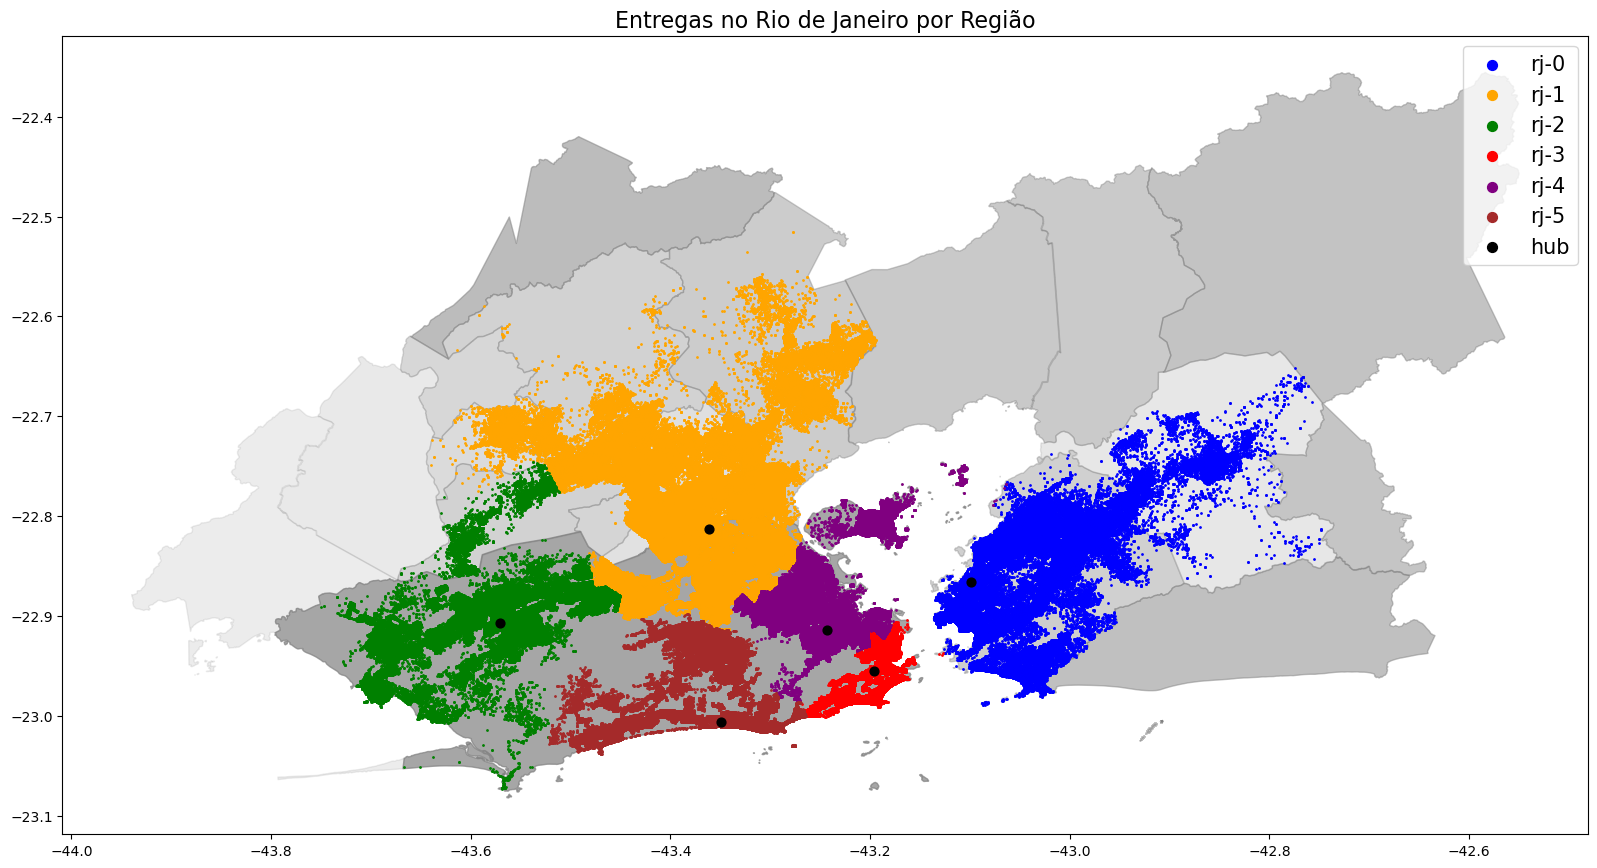

In [47]:
# cria o plot vazio
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# Cria o plot da cidade
mapa_cidade_rj.plot(ax=ax, alpha=0.7, color="gray", edgecolor='gray')
mapa_cidade_itaguai.plot(ax=ax, alpha=0.15, color="gray", edgecolor='gray')
mapa_cidade_seropedica.plot(ax=ax, alpha=0.17, color="gray", edgecolor='gray')
mapa_cidade_itaborai.plot(ax=ax, alpha=0.19, color="gray", edgecolor='gray')
mapa_cidade_sjmeriti.plot(ax=ax, alpha=0.21, color="gray", edgecolor='gray')
mapa_cidade_nilopolis.plot(ax=ax, alpha=0.23, color="gray", edgecolor='gray')
mapa_cidade_belford.plot(ax=ax, alpha=0.25, color="gray", edgecolor='gray')
mapa_cidade_queimados.plot(ax=ax, alpha=0.28, color="gray", edgecolor='gray')
mapa_cidade_japeri.plot(ax=ax, alpha=0.31, color="gray", edgecolor='gray')
mapa_cidade_mesquita.plot(ax=ax, alpha=0.33, color="gray", edgecolor='gray')
mapa_cidade_novaiguacu.plot(ax=ax, alpha=0.35, color="gray", edgecolor='gray')
mapa_cidade_sgoncalo.plot(ax=ax, alpha=0.37, color="gray", edgecolor='gray')
mapa_cidade_niteroi.plot(ax=ax, alpha=0.39, color="gray", edgecolor='gray')
mapa_cidade_duquecaxias.plot(ax=ax, alpha=0.40, color="gray", edgecolor='gray')
mapa_cidade_guapimirim.plot(ax=ax, alpha=0.41, color="gray", edgecolor='gray')
mapa_cidade_mage.plot(ax=ax, alpha=0.42, color="gray", edgecolor='gray')
mapa_cidade_tangua.plot(ax=ax, alpha=0.45, color="gray", edgecolor='gray')
mapa_cidade_cachoeiras.plot(ax=ax, alpha=0.47, color="gray", edgecolor='gray')
mapa_cidade_marica.plot(ax=ax, alpha=0.49, color="gray", edgecolor='gray')
mapa_cidade_mpereira.plot(ax=ax, alpha=0.52, color="gray", edgecolor='gray')

# plot das entregas                                           
geo_deliveries_df.query("region == 'rj-0'").plot(ax=ax, markersize=1, color="blue", label="rj-0")
geo_deliveries_df.query("region == 'rj-1'").plot(ax=ax, markersize=1, color="orange", label="rj-1")
geo_deliveries_df.query("region == 'rj-2'").plot(ax=ax, markersize=1, color="green", label="rj-2")
geo_deliveries_df.query("region == 'rj-3'").plot(ax=ax, markersize=1, color="red", label="rj-3")
geo_deliveries_df.query("region == 'rj-4'").plot(ax=ax, markersize=1, color="purple", label="rj-4")
geo_deliveries_df.query("region == 'rj-5'").plot(ax=ax, markersize=1, color="brown", label="rj-5")

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=40, marker="o", color="black", label="hub")

# plot da legenda
plt.title("Entregas no Rio de Janeiro por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legend_handles:
    handle.set_sizes([50])

# Exibi uma imagem com o mapa do Rio de Janeiro a fim de facilitar a visualização dos dados
plot_width, plot_height = fig.get_size_inches() * fig.dpi
display(Image(url="https://forest-gis.com/wp-content/uploads/2020/07/rio_metro_prod2.png", width=plot_width))


 ### **Insights**:

1. Todas as **entregas** respeitam estritamente os limites territoriais de seus **hubs**;

1. Os **hubs** das regiões 0, 1 e 2 fazem **entregas** em mais de um municipio, o que pode gerar um tempo e preço de entrega maior.

1. O **hub** 1 tem a maior área de cobertura seguido pelo **hub** 0.

1. O **hub** 3 tem a menor área de cobertura seguido pelo **hub** 5

1. A cidade do Rio de Janeiro tem 5 dos 6 **hubs** dentro do seu território. O que indica uma enorme demanda neste municipio.




---



## **5.2. Gráfico de entregas por região** 

Vamos trabalhar sob os dados de locais de **entregas** obtidos e analisá-los defronte às regiões dos **hubs**:

 #### **Preparação: Agregação das entregas por região**

In [48]:
data = pd.DataFrame(deliveries_df[['region', 'vehicle_capacity']].sort_values(by='region'))
data = data.value_counts(normalize=True).reset_index()
data.rename(columns={0: "region_percent"}, inplace=True)
data

region  vehicle_capacity  region_percent
0   rj-1               180        0.255617
1   rj-3               180        0.197317
2   rj-4               180        0.192899
3   rj-0               180        0.142174
4   rj-5               180        0.138070
5   rj-2               180        0.073923

#### **Visualização: Proporção de entregas por região**

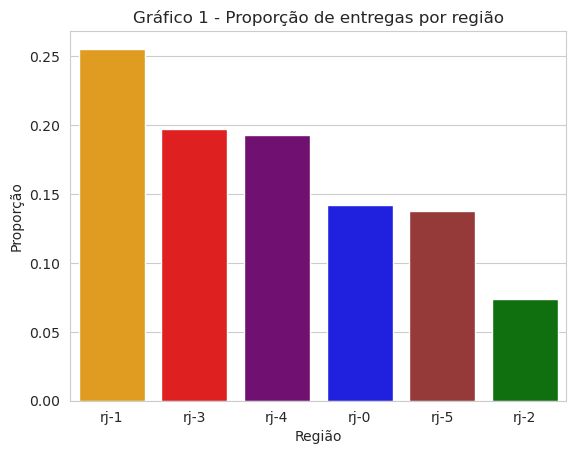

In [49]:
with sns.axes_style('whitegrid'):
  colors = ['orange', 'red', 'purple', 'blue', 'brown', 'green']
  grafico = sns.barplot(data=data, x="region", y="region_percent", errorbar=None, palette=colors)
  grafico.set(title='Gráfico 1 - Proporção de entregas por região', xlabel='Região', ylabel='Proporção');

 ### **Insights**:

1. A distribuição das **entregas** está muito concentrada nos **hubs** das regiões 1 e 3, mas pouco no da região 0. Contudo a capacidade dos veículos é mesma para todos os **hubs**, logo os **veículos** poderiam ser deslocados para as regiões de maior tráfego.

---

## **5.3. Entregas por limite municipal** 

 #### **Preparação: Agregação das entregas por limite municipal**

Iremos agora determinar a localização das entregas de acordo com os limites oficiais de municípios e não apenas por região. Começamos por pegar as coordenadas de cada ponto de **entrega** e verificar dentro dos limites de qual **município** ele se encontra. Para fazer essa comparação usaremos a função `sjoin` com o parâmetro `predicate='within'`.

In [50]:
delivery_bycity = geopandas.sjoin(geo_deliveries_df, mapa, predicate='within')

In [51]:
print(f"{geo_deliveries_df.columns.to_list()}\n{delivery_bycity.columns.to_list()}")

['name', 'region', 'origin_lng', 'origin_lat', 'hub_city', 'hub_suburb', 'vehicle_capacity', 'delivery_size', 'delivery_lng', 'delivery_lat', 'geometry']
['name', 'region', 'origin_lng', 'origin_lat', 'hub_city', 'hub_suburb', 'vehicle_capacity', 'delivery_size', 'delivery_lng', 'delivery_lat', 'geometry', 'index_right']


Note acima que o resultado é uma coluna adicional (ao fim) chamada **index_right** que indica o índice de cada cidade obtidos dos dados cartográficos baixados. Manualmente foram nomeados os índices abaixo:

In [52]:
index_to_city = {
    8: 'Belford Roxo',
    12: 'Cachoeiras de Macacu',
    24: 'Duque de Caxias',
    26: 'Guapimirim',
    28: 'Nova Iguacu',
    38: 'Queimados',
    49: 'Itaborai',
    50: 'Itaguai',
    55: 'Japeri',
    59: 'Magé',
    61: 'Marica',
    63: 'Mesquita',
    64: 'Miguel Pereira',
    67: 'Nilópolis',
    68: 'Niterói',
    70: 'Rio de Janeiro',
    74: 'São Goncalo',
    77: 'São João de Meriti',
    81: 'Seropedica',
    84: 'Tanguá'
}

#### **Preparação: Mapeamento do número entregas por Município**

Mapearemos o nome dessas cidades com seus respectivos índices em uma coluna chamada **delivery_city** e restringiremos o dataframe para apenas três colunas, sendo uma delas a contagem de entregas por município que é nosso dado de interesse:

In [53]:
delivery_bycity['delivery_city'] = delivery_bycity['index_right'].map(index_to_city)
delivery_bycity = delivery_bycity[['region', 'delivery_city', 'delivery_size']]
delivery_bycity = delivery_bycity.groupby(['region', 'delivery_city']).size().reset_index(name='count')

Para melhorar a visualização, retiramos os municípios com um número insignificante de entregas (n<20):

In [54]:
delivery_bycity = delivery_bycity[delivery_bycity['count']>20]
delivery_bycity = delivery_bycity.sort_values(by='region', ascending=True)

In [55]:
delivery_bycity

region       delivery_city   count
1    rj-0            Itaborai    8581
3    rj-0             Niterói   68444
4    rj-0         São Goncalo   47614
6    rj-1        Belford Roxo   16184
7    rj-1     Duque de Caxias   34396
8    rj-1            Mesquita    7952
10   rj-1           Nilópolis    8665
11   rj-1         Nova Iguacu   26813
12   rj-1           Queimados    4764
13   rj-1      Rio de Janeiro  106601
14   rj-1  São João de Meriti   19555
15   rj-2         Nova Iguacu    4473
17   rj-2      Rio de Janeiro   60466
20   rj-3      Rio de Janeiro  171608
21   rj-4      Rio de Janeiro  169496
23   rj-5      Rio de Janeiro  121083

#### **Visualização: Número de entregas por Município**

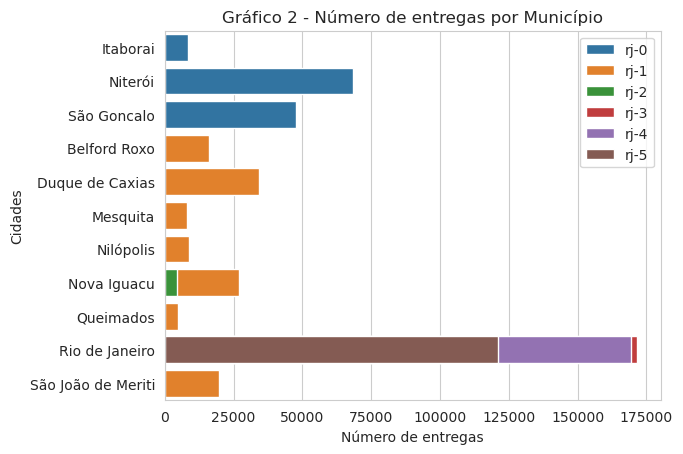

In [56]:
with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=delivery_bycity, x='count', y='delivery_city', hue='region', dodge=False, errorbar=None)
  grafico.set(title='Gráfico 2 - Número de entregas por Município', xlabel='Número de entregas', ylabel='Cidades')
  plt.legend(loc='upper right')

### **Insights:**

1. Como visto no *Gráfico 1*, as regiões `rj-1, rj-3` são, respectivamente, as com maior número de entregas. E neste gráfico é possível concluir que apesar da região `rj-1` atender diversas cidades diferentes, a região **`rj-3`** apenas com a cidade do Rio de Janeiro consegue **superar em número de entregas**.

2. O Município com o **segundo maior** número de entregas é **Niterói**, seguido por São Gonçalo.

#### **Visualização: Número de municípios atendidos por região**

In [57]:
cities_byregion_df = delivery_bycity.groupby('region')['delivery_city'].agg('count').reset_index()
cities_byregion_df

region  delivery_city
0   rj-0              3
1   rj-1              8
2   rj-2              2
3   rj-3              1
4   rj-4              1
5   rj-5              1

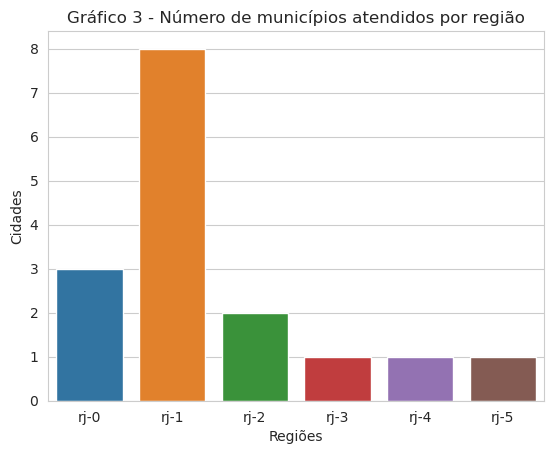

In [58]:
with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=cities_byregion_df, x='region', y='delivery_city')
  grafico.set(title= 'Gráfico 3 - Número de municípios atendidos por região', xlabel='Regiões', ylabel='Cidades')

### **Insights:**


1.   É possível notar que a região `rj-1` atende em média **5x mais municípios** que os **hubs** das outras regiões.
2.   Dos 6 **hubs** na região da capital, 50% atende somente a cidade do Rio e 50% atende outros municípios da região metropolitana.


#### **Visualização: Número de entregas por região do *hub***

In [59]:
deliveries_byregion_df = delivery_bycity.groupby('region').sum(numeric_only=True).reset_index()
deliveries_byregion_df

region   count
0   rj-0  124639
1   rj-1  224930
2   rj-2   64939
3   rj-3  171608
4   rj-4  169496
5   rj-5  121083

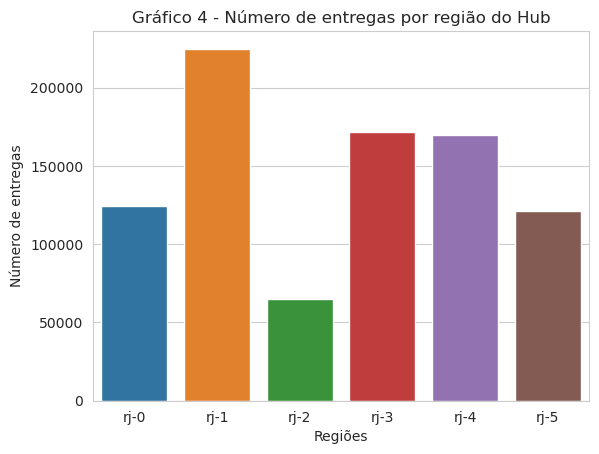

In [60]:
with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=deliveries_byregion_df, x='region', y='count')
  grafico.set(title='Gráfico 4 - Número de entregas por região do Hub', xlabel='Regiões', ylabel='Número de entregas')

### **Insights:**


1.   Teoricamente o mesmo que o *Gráfico 1*, no entanto com o número de entregas. Nele concluímos que a região `rj-2` apesar de a menor ainda assim entregou 64.000 encomendas um número razoável.

2. A região `rj-1` com o maior número de entregas fez 220.000 no período estudado.


# 6\. Conclusão

Nessa análise foi possível entender melhor o funcionamento da logística da empresa Loggi e como ela tem sido bem sucedida em seu  alcançe na região metropolitana do Rio de Janeiro. Notamos também que a maior parte das entregas estão concentradas na capital, onde a maior parte dos Hubs se concentra, mas que apesar disso há uma distribuição muito ampla atingindo cerca de 20 cidades. Nos gráficos foi possível compreender melhor o papel de cada Hub, alguns com entregas concentradas e numerosas, outros com entregas distantes. A medidade que a adoção por compras no comércio eletrônico aumenta, essa análise ajudará na escolha da localização dos próximos Hubs que serão necessários para atender a crescente demanda.